In [25]:
import pandas as pd
from datetime import datetime

def clean_reolink_log(path, skip=8):
    reo1 = pd.read_csv(path, skiprows=skip, header=None).rename(columns={1: "source", 2: "API_request",
                                                                     3: "API_code", 4: "Alarm"})
    reo1["Time"] = reo1.loc[:,0].str.split(" \[    INFO] ")
    # pd.to_datetime(reo1.loc[0,0], format='%Y-%m-%d %H:%M:%S')
    ind1 = [True if i % 2 == 0 else False for i in range(len(reo1.Time.explode())) ]
    ind2 = [False if i % 2 == 0 else True for i in range(len(reo1.Time.explode())) ]

    T = pd.concat([reo1.Time.explode().iloc[ind1], reo1.Time.explode().iloc[ind2]], axis=1)
    T.columns = ["camera_time", "log_time"]
    reo1 = pd.concat([T,reo1.loc[:,["source","API_request","API_code","Alarm"]]], axis=1)
    

    # datetime.strptime(reo1.loc[0,"camera_time"], '%Y-%m-%d %M:%S:%f')
    reo1.loc[:,"camera_time"] = pd.to_datetime(reo1.loc[:,"camera_time"], format='%Y-%m-%d %H:%M:%S')
    reo1 = reo1.drop_duplicates("camera_time").set_index("camera_time").resample('S')#.ffill().fillna(0)
    reo1 = reo1.asfreq(0)
    return reo1

path = "Reolink/log/Reolink_motion_alerts_Eingang_part2.log"

reo1 = clean_reolink_log(path)
reo1 = clean_reolink_log(path)

In [39]:
reo1.Alarm.value_counts()

0    227149
1     10769
Name: Alarm, dtype: int64

<AxesSubplot:xlabel='camera_time'>

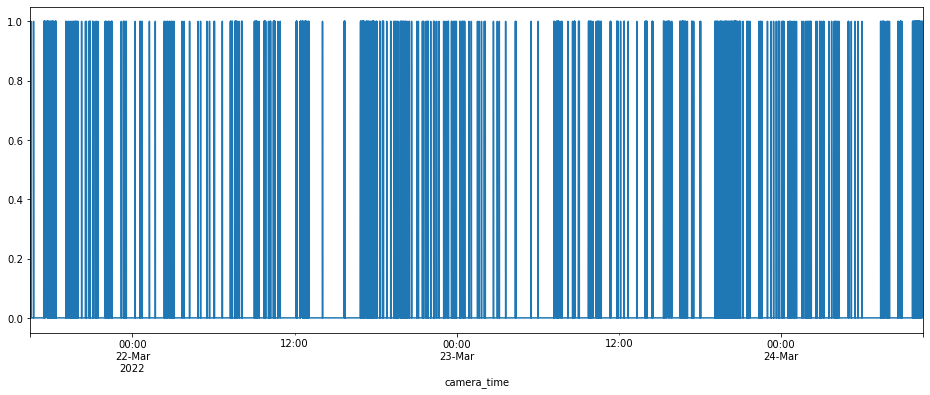

In [183]:
reo1.loc[:,"Alarm"].interpolate(method='linear').plot(figsize = (16,6))

In [184]:
import os
path = [l for l in  os.listdir("Reolink/log/") if re.match(".*.log", l)]

reo = clean_reolink_log("Reolink/log/" + path[0])
# reo
for r,skip in zip(path[1:], [32,48,8,8,8,8,8]):
    print(r)
    reo = reo.append(clean_reolink_log("Reolink/log/" + r, skip))
    
reo.shape
                     


Reolink_motion_alerts_Eingang.log
Reolink_motion_alerts_Eingang_part12.log
Reolink_motion_alerts_Eingang_part4.log
Reolink_motion_alerts_Eingang_part5.log
Reolink_motion_alerts_Eingang_part7.log
Reolink_motion_alerts_Eingang_part1.log
Reolink_motion_alerts_Eingang_part2.log


(939932, 5)

In [2]:
import pandas as pd
import re

def clean_YOLO_log(yolo):
    with open(yolo) as f:
        f = f.read()

    r = re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\d{4,4})x(\d+) stream @ (\d+ FPS).*")
    startings = re.findall(r, f)
#     print(startings, len(startings))

    test2 = re.split(".*\d{4,4}-\d+-\d+ [\d:]+ \[\s+INFO] \d{4,4}x\d+ stream @ \d+ FPS.*", f)

    important = []
    imp = []
    keep_phrases = ["Found",
                  "Reidentified",
                  "Lost",
                   "out_of_area"]
    p =re.compile(".*(\d{4,4}-\d+-\d+ [\d:]+) \[\s+INFO] (\w+):\s+[-0-9a-z]+.?\w+.?\d{0,14}.?\s{0,14}(\d+).*")


    for t in test2[1:]:
        L = t.split("\n")
        for line in L:
            for phrase in keep_phrases:
                if phrase in line:            
                    imp.append([p.search(line).group(i) for i in range(1,4)])
                    break
        important.append(imp)
        imp = []



    DF_in_area = []
    DF_in_and_out_area = []
    for I in range(len(important)):
        if (important[I] != []) & (len(important[I]) != 1):
#             print("len important for incidence I {} - {}".format(I, len(important[I])))
            YOLO = pd.DataFrame(important[I], columns=["time", "status","trackID"])
            YOLO.loc[:,"time"] = pd.to_datetime(YOLO.loc[:,"time"], format='%Y-%m-%d %H:%M:%S')

#             print(YOLO.value_counts("status"))

            start = YOLO[YOLO.isin(["Found", "Reidentified"]).status]
            stop = YOLO[YOLO.isin(["Lost"]).status]
            out= YOLO[YOLO.isin(["out_of_area"]).status]
#             print(start.shape, stop.shape, out.shape)

            start["Time"] = start.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sta = start.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"start"})
            stop["Time"] = stop.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            sto = stop.groupby("trackID")['Time'].apply(lambda x: "%s" % ', '.join(x)).to_frame().rename(columns={"Time":"stop"})
            out["Time"] = out.time.dt.strftime('%Y-%m-%d %H:%M:%S')
            o = out.groupby("trackID")['Time'].min().to_frame().rename(columns={"Time":"start"})    
#             print(sta.shape, sto.shape, o.shape)

            test = pd.concat([sta, sto], join="inner", axis=1)
            test = test.apply(lambda x: x.str.split(","))
            ind = test.apply(lambda x: len(x["start"])-len(x["stop"]), axis=1) != 0
            ok = test[ind==False]
            not_ok = test[ind]

            ok = ok.explode(["start", "stop"])

            ok_all = ok.copy()
            not_ok_all = not_ok.copy()

            for k,v in o.start.to_dict().items():
                if k in ok.index:
#                     print(k)
                    if isinstance(ok.loc[k,"start"], pd.Series):
                        if sum(ok.loc[k,"start"] == v):
                            backup = ok.loc[k,:][ok.loc[k,"start"] == v].copy()
#                             display(backup)
#                             print("bingo")
                            ok = ok.drop(index=[k])
                            ok = ok.append(backup)
                    elif isinstance(ok.loc[k,"start"], str):
                        if ok.loc[k,"start"] == v:    
#                             print("bingo")
                            ok = ok.drop(index=[k])



            ok.start = pd.to_datetime(ok.start)
            ok.stop = pd.to_datetime(ok.stop)
            ok_all.start = pd.to_datetime(ok_all.start)
            ok_all.stop = pd.to_datetime(ok_all.stop)

            s, w,h, fps = startings[I]
            s = pd.to_datetime(s)

            for z,OK in enumerate([ok, ok_all]):
                ix = pd.date_range(s, OK.stop.max(), freq="s")
                df = pd.DataFrame(0, columns=["event"], index=ix)


                for i,r in OK.iterrows():
                    ix = pd.date_range(r["start"],r["stop"], freq="s")
                    df_new = pd.DataFrame({'event': 1}, index=ix)
                    df.loc[df_new.index,] = 1

                if z == 0:
                    DF_in_area.append(df) 
                elif z == 1:
                    DF_in_and_out_area.append(df)    
                
    return DF_in_and_out_area, DF_in_area, startings


yolo = "smart_surveillance/log/YOLO4_DeepSORT_Eingang_overview_part6.log"

DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log(yolo)
    

/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [4]:
import os
path = [l for l in  os.listdir("smart_surveillance/log/") if re.match("YOLO4_DeepSORT_Eingang_.*.log", l)]

print(path[0])
DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log("smart_surveillance/log/" + path[0])

DF_in =DF_in_area[0].copy()
DF_in_out =DF_in_and_out_area[0].copy()
for i in range(1,len(DF_in_area)):
    DF_in = DF_in.append(DF_in_area[0]) 
    DF_in_out =DF_in_out.append(DF_in_and_out_area[0])
        
for j in range(1,len(path)):
    print(path[j])
    DF_in_and_out_area, DF_in_area, startings = clean_YOLO_log("smart_surveillance/log/" + path[j])
    
#     DF_in =DF_in_area[0].copy()
#     DF_in_out =DF_in_and_out_area[0].copy()
    for k in range(len(DF_in_area)):
        DF_in = DF_in.append(DF_in_area[k]) 
        DF_in_out =DF_in_out.append(DF_in_and_out_area[k])

# # reo
# for r,skip in zip(path[1:], [32,48,8,8,8,8,8]):
#     print(r)
#     reo = reo.append(clean_reolink_log("Reolink/log/" + r, skip))
    
# reo.shape

YOLO4_DeepSORT_Eingang_overview_part8.log


/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/brunosa3/anaconda3/envs/capstone_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

YOLO4_DeepSORT_Eingang_overview_part16.log
YOLO4_DeepSORT_Eingang_overview_part17.log
YOLO4_DeepSORT_Eingang_overview.log
YOLO4_DeepSORT_Eingang_overview_part13.log
YOLO4_DeepSORT_Eingang_overview_part7.log
YOLO4_DeepSORT_Eingang_overview_part15.log
YOLO4_DeepSORT_Eingang_overview_part14.log


ValueError: Neither `start` nor `end` can be NaT

In [171]:
DF_in.index.max()

Timestamp('2022-03-25 21:37:17')

In [173]:
DF_in.shape, DF_in_area[-1].shape

((596652, 1), (236162, 1))

In [34]:
startings

[('2022-03-20 13:37:58', '2304', '1296', '10 FPS'),
 ('2022-03-21 11:53:38', '2304', '1296', '10 FPS'),
 ('2022-03-21 13:58:24', '2304', '1296', '10 FPS'),
 ('2022-03-21 15:02:05', '2560', '1920', '10 FPS'),
 ('2022-03-21 15:46:11', '2560', '1920', '10 FPS'),
 ('2022-03-21 16:21:19', '2560', '1920', '10 FPS')]

In [ ]:
reo.loc[:,"Alarm"].interpolate(method='linear').plot(figsize = (16,6))

<AxesSubplot:xlabel='camera_time'>

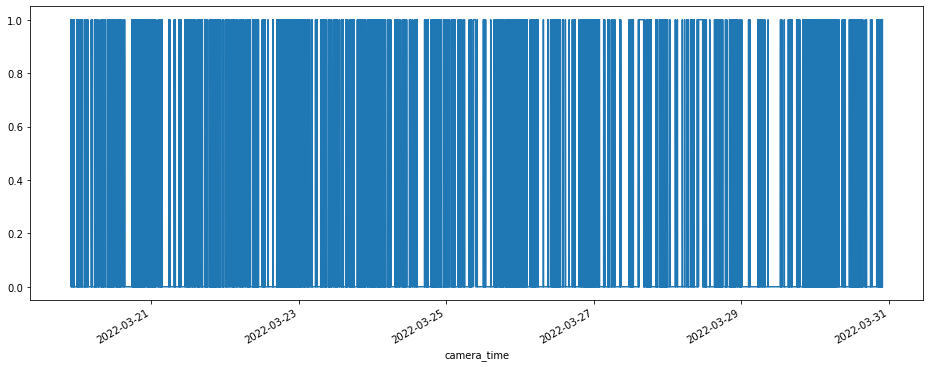

In [93]:
reo.loc[:,"Alarm"].interpolate(method='linear').plot(figsize = (16,6))

<AxesSubplot:xlabel='camera_time'>

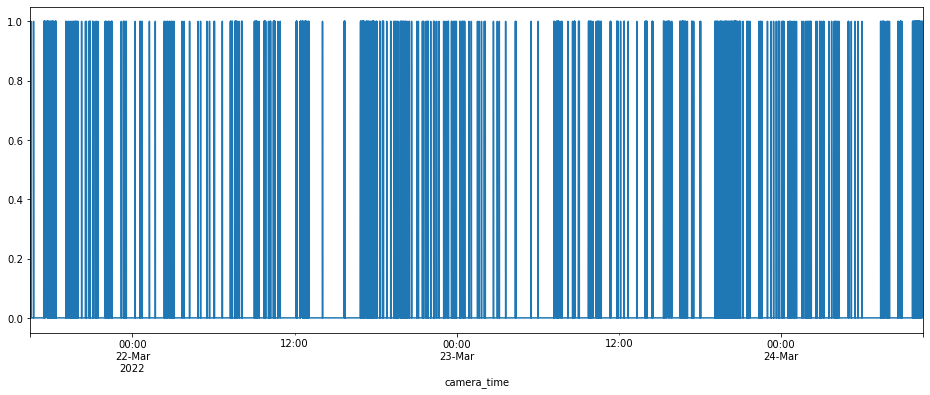

In [186]:
reo1.loc[:,"Alarm"].interpolate(method='linear').plot(figsize = (16,6))

<AxesSubplot:>

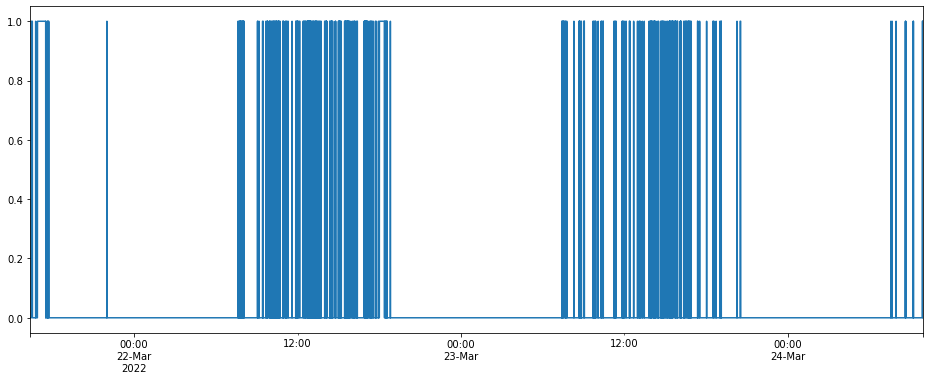

In [177]:
DF_in_and_out_area[5].loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))

<AxesSubplot:>

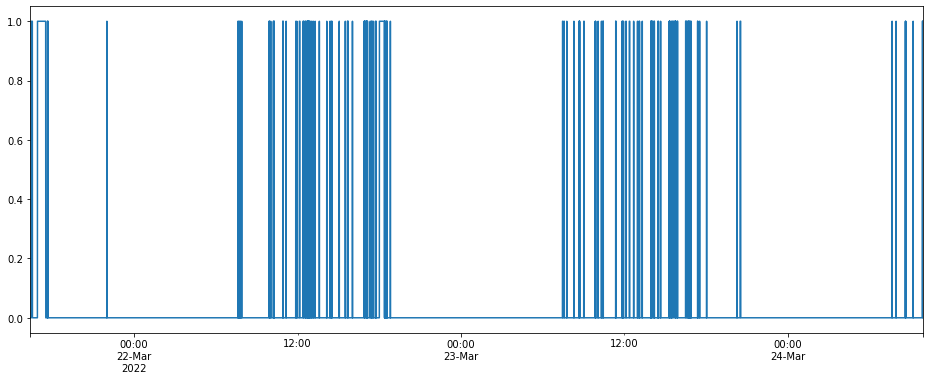

In [36]:
DF_in_area[5].loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))

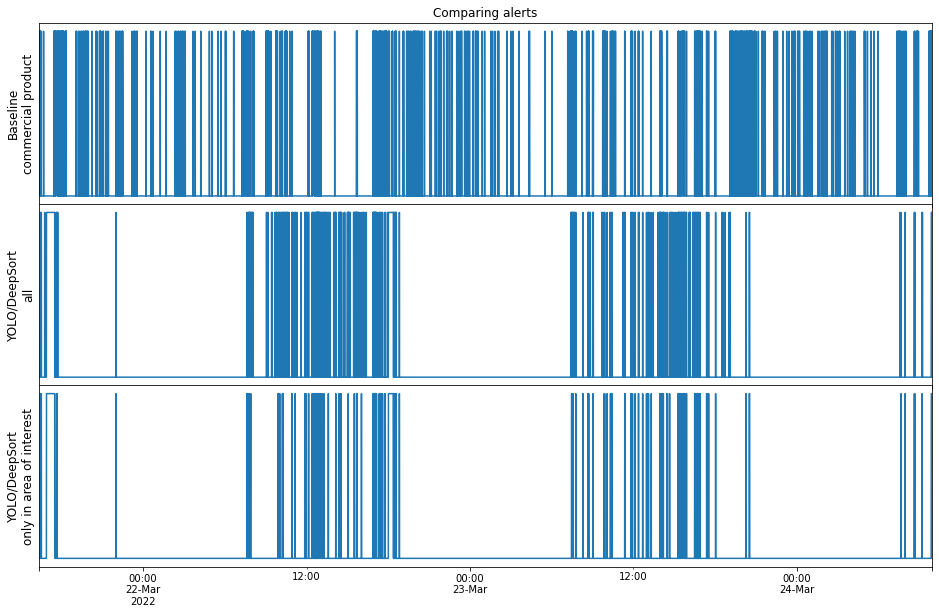

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, figsize = (16,10), sharex = True)

ax[0].set_title("Comparing alerts", rotation=0, size='large')

ax[0].set_ylabel("Baseline\ncommercial product", rotation=90, size='large')
reo1.loc[:,"Alarm"].interpolate(method='linear').plot( ax=ax[0])
ax[0].axes.get_yaxis().set_ticks([])

ax[1].set_ylabel("YOLO/DeepSort\nall", rotation=90, size='large')
DF_in_and_out_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[1])
ax[1].axes.get_yaxis().set_ticks([])

DF_in_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[2])
ax[2].axes.get_yaxis().set_ticks([])
ax[2].set_ylabel("YOLO/DeepSort\nonly in area of interest", rotation=90, size='large')

plt.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

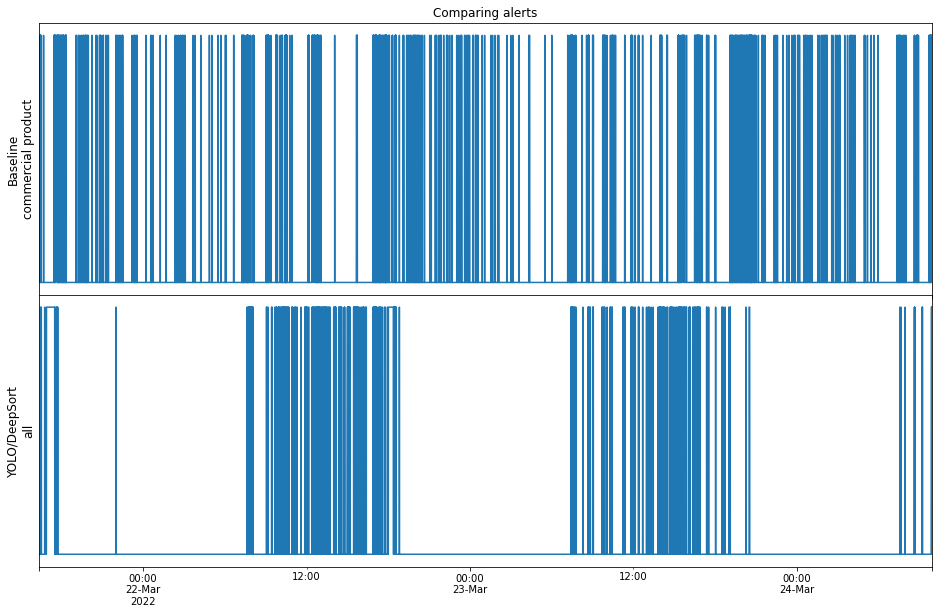

In [79]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize = (16,10), sharex = True)

ax[0].set_title("Comparing alerts", rotation=0, size='large')

ax[0].set_ylabel("Baseline\ncommercial product", rotation=90, size='large')
reo1.loc[:,"Alarm"].interpolate(method='linear').plot( ax=ax[0])
ax[0].axes.get_yaxis().set_ticks([])

ax[1].set_ylabel("YOLO/DeepSort\nall", rotation=90, size='large')
DF_in_and_out_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[1])
ax[1].axes.get_yaxis().set_ticks([])

# DF_in_area[5].loc[:,"event"].interpolate(method='linear').plot(ax=ax[2])
# ax[2].axes.get_yaxis().set_ticks([])
# ax[2].set_ylabel("YOLO/DeepSort\nonly in area of interest", rotation=90, size='large')

plt.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

In [179]:
DF_in =DF_in_area[0].copy()
DF_in_out =DF_in_and_out_area[0].copy()
for i in range(1,6):
    DF_in = DF_in.append(DF_in_area[i]) 
    DF_in_out =DF_in_out.append(DF_in_and_out_area[i])


<AxesSubplot:>

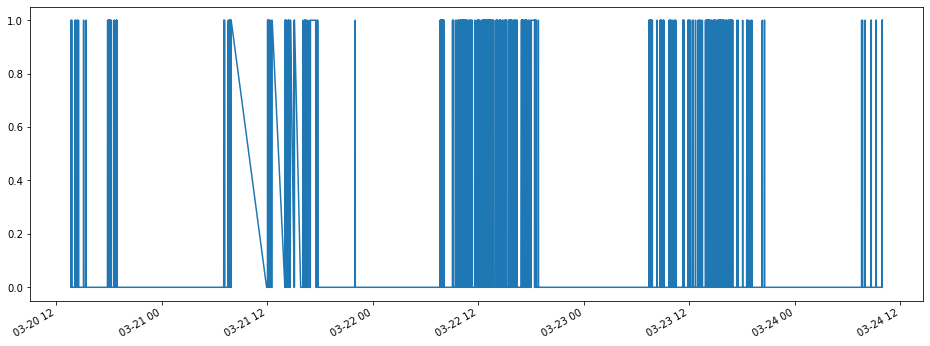

In [180]:
DF_in_out.loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))

<AxesSubplot:>

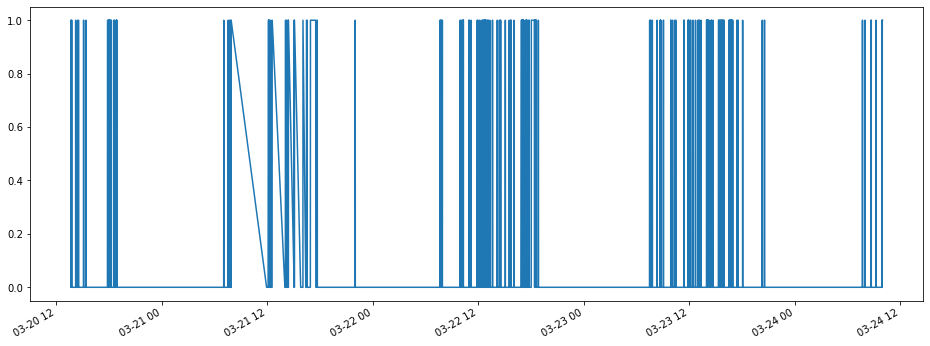

In [181]:
DF_in.loc[:,"event"].interpolate(method='linear').plot(figsize = (16,6))